In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import spacy
import numpy as np
import pandas as pd


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Mtech /Dissertation/data_output/raw_data_converted_without_fp.csv')
mask = data['status'] == 'completed'
data['label'] = mask.map({True: 1, False: 0})
data= data.fillna("")
nlp = spacy.load("en_core_sci_sm")

In [ ]:
data.columns

Index(['Unnamed: 0', 'nctid', 'status', 'why_stop', 'label', 'phase',
       'diseases', 'icdcodes', 'drugs', 'smiless', 'criteria',
       'why_stop_updated', 'diseases_updated', 'drugs_updated',
       'criteria_updated', 'combined_text'],
      dtype='object')

In [ ]:
data['combined_text'] = data['why_stop_updated'] + ' ' + data['diseases_updated'] + ' ' + data['drugs_updated'] + ' ' + data['criteria_updated']

In [ ]:
data['label']

In [ ]:
tokens = []
for text in data['combined_text']:
    doc = nlp(text)
    token_list = [token.text for token in doc]
    tokens.append(token_list)

In [ ]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(tokens, vector_size=500, window=5, min_count=1, sg=0)

word_embeddings = word2vec_model.wv

In [ ]:
# Calculate vocab_size as the number of unique tokens
vocab_size = len(word_embeddings.key_to_index)

# Determine embedding_dim based on the dimensionality of your word embeddings
embedding_dim = word2vec_model.vector_size

# Find max_sequence_length as the maximum length of tokenized sequences
max_sequence_length = max(len(tokens) for tokens in tokens)

# Create an embedding_matrix with word embeddings for your vocabulary
embedding_matrix = word_embeddings.vectors  # Use the vectors attribute to get the matrix

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(tokens, data['label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:

# Create a tokenizer and fit it on your training data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# Convert text sequences to sequences of word indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad or truncate sequences to a fixed length (max_sequence_length)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')



model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val))

loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/10
319/319 [==============================] - 677s 2s/step - loss: 36.2842 - accuracy: 0.6950 - val_loss: 5.7608 - val_accuracy: 0.8705
Epoch 2/10
319/319 [==============================] - 674s 2s/step - loss: 8.0594 - accuracy: 0.8460 - val_loss: 9.5253 - val_accuracy: 0.6921
Epoch 3/10
319/319 [==============================] - 669s 2s/step - loss: 2.9865 - accuracy: 0.9128 - val_loss: 5.5942 - val_accuracy: 0.7818
Epoch 4/10
319/319 [==============================] - 668s 2s/step - loss: 2.5181 - accuracy: 0.9253 - val_loss: 7.4819 - val_accuracy: 0.7534
Epoch 5/10
319/319 [==============================] - 682s 2s/step - loss: 4.0888 - accuracy: 0.9049 - val_loss: 16.1699 - val_accuracy: 0.8038
Epoch 6/10
319/319 [==============================] - 665s 2s/step - loss: 1.5658 - accuracy: 0.9424 - val_loss: 9.1488 - val_accuracy: 0.8719
Epoch 7/10
319/319 [==============================] - 662s 2s/step - loss: 0.8660 - accuracy: 0.9598 - val_loss: 11.1704 - val_accuracy: 0.6

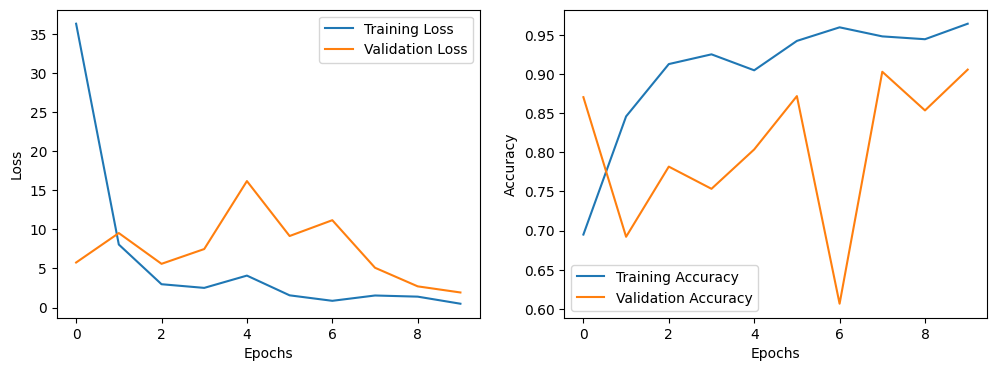

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()